# Solve Sudoku

In [1]:
TRAINING_IMAGES_FOLDER = "data/train/images/"
TRAINING_LABELS_PATH = "data/train/labels.csv"
TEST_IMAGES_FOLDER = "data/test/images"

### Import Libraries

In [2]:
import os
import tqdm

import pandas as pd
import numpy as np

import torch
import torchvision.transforms as transforms
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

import cv2 as cv

### Align Game Grid

In [11]:
def align_img(img):

    # Add border
    img = cv.copyMakeBorder(img, 50, 50, 50, 50, cv.BORDER_CONSTANT, value=(0, 0, 0))

    # Make gray
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply a blur to reduce noise
    blurred = cv.GaussianBlur(gray, (5, 5), 0)

    # Define a 3x3 Sobel filter for detecting horizontal and vertical edges
    edges = cv.Canny(blurred, 100, 200)

    # Find contours in the edge image
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Initialize min/max values
    min_xy, max_xy, min_yx, max_yx = float('inf'), 0, float('inf'), 0

    # Loop over all contours and their points
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if x + y < min_xy:
                top_left = (x, y)
                min_xy = x + y
            if x+y > max_xy:
                bottom_right = (x, y)
                max_xy = x+y
            if y-x < min_yx:
                top_right = (x, y)
                min_yx = y-x
            if x-y < max_yx:
                bottom_left = (x, y)
                max_yx = x-y

    border = np.array([top_left, bottom_left, bottom_right, top_right])

    # Draw the largest contour on the original image
    # cv.drawContours(img, [border], -1, (0, 255, 0), 3)

    # cv.drawMarker(img, bottom_left, color=(255,0,0))
    # cv.drawMarker(img, bottom_right, color=(255,0,0))
    # cv.drawMarker(img, top_right, color=(255,0,0))
    # cv.drawMarker(img, top_left, color=(255,0,0))
    # print(top_right)
    # print(top_left)
    # print(bottom_right)
    # print(bottom_left)


    # cv_imshow(img)

    # Get the minimum bounding rectangle of the border
    # rect = cv.minAreaRect(border)

    # # Calculate the rotation angle of the rectangle
    # angle = rect[2]
 
    # if angle > 0:
    #     border = np.array([top_left, bottom_left, bottom_right, top_right])
    # else:
    #     border = np.array([top_right, top_left, bottom_left, bottom_right])

    # # Apply a perspective transform to get a bird's-eye view of the grid
    src = np.float32(border)
    dst = np.float32([[0, 0], [0, 450], [450, 450], [450, 0]])
    M = cv.getPerspectiveTransform(src, dst)
    warped = cv.warpPerspective(gray, M, (450, 450))

    # cv_imshow(warped)
    
    return warped

### Read Digits

#### Model

The model was trained on the MNIST dataset for 20 epochs. Random noise was added to the training data.
It achieved accuracy of 97% on testing.

That accuracy can't be guaranteed on the application because the quality of the image on the application cannot be guaranteed to approximate the quality of the dataset.

In [69]:
from classifier.DigitClassifier import DigitClassifier
# Load Digit Classifier

# Instantiate model architecture
model = DigitClassifier()

# Load saved model weights
model.load_state_dict(torch.load('classifier\\digit_classifier_very_noisy_21.pth'))

# Set model to evaluation mode
model.eval()

DigitClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#### Image Manipulation

In [39]:
def detect_digit(square):
    '''
    Determines if there exists a digit in the square,
    uses an algorithmic approach, checks if any of the central 10x10
    pixels are not the color of the background 
    '''
    square = (square.numpy() * 255).astype(np.uint8).squeeze()
    ret, square = cv.threshold(square,150,255,cv.THRESH_BINARY)
    square = square[9:19, 9:19] #10x10 square w/out borders
    for i in range(8):
        for j in range(8):
            if (square[i][j]!=0):
                return True
    return False

In [40]:
def remove_grid(square):
    '''
    Attempts to remove the leftover pixels of the grid and leave only the pixels that represent the digits
    '''
    # creates matrix to identify grid and pixels that touch the grid
    touches_grid = torch.zeros_like(square.squeeze())

    square = (square.numpy() * 255).astype(np.uint8).squeeze()
    ret, square = cv.threshold(square,115,255,cv.THRESH_BINARY)
    square = square.astype(np.float32) / 255

    # set borders to true:
    touches_grid[0, :] = 1 #upper border
    touches_grid[-1, :] = 1 #lower border
    touches_grid[:, 0] = 1 #left border
    touches_grid[:, -1] = 1 #right border

    # Iterate through the rows and check if touches grid
    for row in range(1, square.shape[0] - 1):
        for col in range(1, square.shape[1] - 1):
            if square[row, col] != 0 and (touches_grid[row - 1, col] or touches_grid[row, col - 1] or touches_grid[row, col + 1] or touches_grid[row+1, col]):
                touches_grid[row, col] = 1
        
    for row in range(square.shape[0]):
        for col in range(square.shape[1]):
            if touches_grid[row, col] == 1:
                square[row, col] = 0

    square = torch.tensor(square).unsqueeze(0)
    return square
    

In [70]:
def extract_digits(img):

    transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
    ])

    img_digits = []
    digits = []
    for i in range(0, 450, 50):
        for j in range(0, 450, 50):
            img_digit = img[i:i+50, j:j+50]
            img_digit = -transform(Image.fromarray(img_digit)) + 1

            if detect_digit(img_digit):
                img_digit = remove_grid(img_digit)
                #thresholding
                #img_digit[img_digit < 0.5] = 0
                img_digits.append(img_digit)
                # plt.imshow(img_digit.squeeze(), cmap='gray')
                # plt.show()

                output = model(img_digit)
                digit = torch.argmax(output, dim=1).item()
                # print(f'digit: {digit}, confidence: {torch.max(torch.softmax(output, dim=1))}')
                digits.append(digit)             
            else:
                img_digits.append(img_digit)
                digits.append(0)

    digits = np.array(digits).reshape((9,9))

    return digits


### Sudoku Solver

In [42]:
from sudoku import Sudoku

#Solves row major form puzzles
def findSolution(game):
  puzzle = Sudoku(3, 3, board=game.reshape(9,9).tolist())
  solution = puzzle.solve()

  if solution.board[0][0] == None:
    return game

  solutionString = np.array(solution.board).reshape(81)

  return solutionString

### Putting It All Together

In [71]:
training_labels_df = pd.read_csv(TRAINING_LABELS_PATH)

X = []
y = []

for _idx, row in tqdm.tqdm(training_labels_df.iterrows(), total=training_labels_df.shape[0]):
    filepath = os.path.join(
        TRAINING_IMAGES_FOLDER,
        f"{row.id:04d}.png"
    )
    img = cv.imread(filepath)

    img_aligned = align_img(img)
    
    data_X = extract_digits(img_aligned)
    # convert to list of chars
    data_y = list(map(int, row.solution))
    
    X.extend(data_X)
    y.extend(data_y)

X = np.array(X)
y = np.array(y)

100%|██████████| 5000/5000 [1:11:33<00:00,  1.16it/s]


In [72]:
np.savetxt("all_games_5.csv", X, delimiter=",")

In [77]:
X = np.genfromtxt('all_games_5.csv', delimiter=',').astype(int)
# y = np.genfromtxt('all_solutions.csv', delimiter=',').astype(int)

In [78]:
X = X.reshape(5000, 81)
y = y.reshape(5000, 81)

X_solved = []

for game in X.astype(int):
    X_solved.append(findSolution(game))

X_solved = np.array(X_solved)
#X_solved[X_solved == 0] = 5

# Calculate the MSE loss between x and y
loss = np.mean(np.square(X_solved - y))
print(loss)

solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
solved game!
21.617572839

best result: 5.3259185185185185

In [81]:
X_solved_filtered = X_solved[X_solved != 0]
X_solved_filtered

array([7, 9, 9, ..., 1, 5, 2])

In [82]:
y_filtered = y[X_solved != 0]
y_filtered

array([7, 9, 4, ..., 1, 5, 2])

In [83]:
# Calculate accuracy
accuracy = np.sum(X_solved_filtered == y_filtered) / len(X_solved_filtered)
print('Accuracy:', accuracy)

Accuracy: 0.7739406899677108


In [75]:
# Calculate accuracy
accuracy = np.sum(X_solved == y) / len(X_solved)
print('Accuracy:', accuracy)

Accuracy: 27.6898


Accuracy: 27.6898

[[    0     0     0     0     0     0     0     0     0     0]
 [29990 12515   610     3   207    55    17   407   356   840]
 [29620    12 13606   128    20  1181    10   342    47    34]
 [29679   187   153 13044    74   863    17   121    54   808]
 [29556   175   498     2 10178   213  2971    34   802   571]
 [29597     2    32   147   103 13824    96   138   248   813]
 [29552     0    18     0   500  1899 11909     2   491   629]
 [30526   256    94    44   231    41    10 13594     1   203]
 [29648     3   214  1422  1018   256  1841     5  6104  4489]
 [29733    25    19    26  1156  1053   440    49     3 12496]]


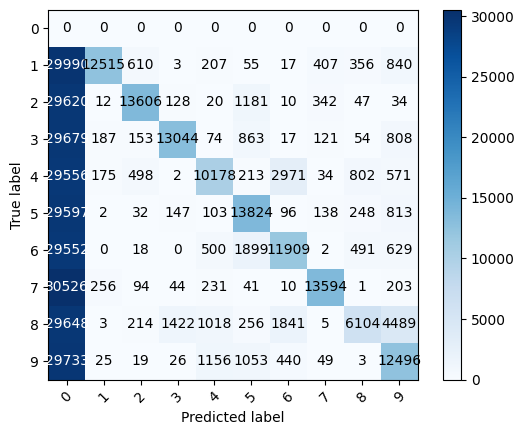

In [76]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Generate example data
y_true = y.flatten()
y_pred = X.flatten()

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set ticks and tick labels
ax.set_xticks(np.arange(len(np.unique(y_pred))))
ax.set_yticks(np.arange(len(np.unique(y_pred))))
ax.set_xticklabels(np.unique(y_pred))
ax.set_yticklabels(np.unique(y_pred))
ax.tick_params(axis='x', labelrotation=45)

# Add annotations
thresh = cm.max() / 2.0
for i in range(len(np.unique(y_pred))):
    for j in range(len(np.unique(y_pred))):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Set labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Show plot
plt.show()